In [1]:
from evalutils import *
from os import path
import matplotlib.pyplot as plt
import scipy.stats

def gather_learning_curve_results(learners, datasets, seeds):
    
    # read in data frame if exists
    FILENAME = "data/learningcurves.csv"
    cols = ["openmlid", "learner", "train_size", "seed", "traintime", "error_rate"]
    df = pd.read_csv(FILENAME) if path.exists(FILENAME) else pd.DataFrame([], columns=cols)
    
    total = len(datasets) * len(learners) * len(seeds)
    pbar = tqdm(total=total)
    rows = []
    unsaved_changes = 0
    interrupted = False
    for openmlid in datasets:
        dsIndex = df["openmlid"] == openmlid
        
        print("DATASET", openmlid)
        X, y = get_dataset(openmlid)
        n = X.shape[0]
        max_exponent = np.log(n - 100) / np.log(2)
        exponents = [i for i in range(6, int(np.floor(max_exponent + 1)))]
        exponents.append(max_exponent)
        print("Exponents:", exponents, "Sizes:", [2**e for e in exponents])
        if n == 0:
            print("Omit empty dataset!")
        
        if interrupted:
            break
        
        for seed in seeds:
            if interrupted:
                break
            dsSeed = dsIndex & (df["seed"] == seed)
            for j, learner in enumerate(learners):
                if interrupted:
                    break
                dsLearner = dsSeed & (df["learner"] == str(learner))
                scores_val = []
                slopes = []
                try:
                    for i, exponent in enumerate(exponents):
                        if interrupted:
                            break
                        random.seed(seed)
                        num_examples = int(2**exponent)
                        if n - num_examples < 100:
                            print("Dataset has only " + str(n) +" instances in total. That is not enough samples to train on " + str(num_examples) + ". Skipping")
                        else:
                            dsPortion = dsLearner & (df["train_size"] == num_examples)
                            if np.count_nonzero(dsPortion) == 0:
                                print("Creating Random Split for seed " + str(seed))
                                indices_train = random.sample(range(n), num_examples)
                                mask_train = np.zeros(n)
                                mask_train[indices_train] += 1
                                mask_train = mask_train.astype(bool)
                                print(mask_train)
                                mask_test = ~mask_train
                                print(np.count_nonzero(mask_train), np.count_nonzero(mask_test))
                                X_train = X[mask_train]
                                y_train = y[mask_train]
                                X_test = X[mask_test][:10000]
                                y_test = y[mask_test][:10000]

                                inst = learner()
                                print("Training " + str(learner) + " on data of shape " + str(X_train.shape))
                                tic = time.time()
                                inst.fit(X_train, y_train)
                                print("Training ready. Obtaining predictions for " + str(X_test.shape[0]) + " instances.")
                                y_hat = inst.predict(X_test)
                                toc = time.time()
                                runtime = int(np.round((toc - tic) * 1000))
                                error_rate = 1 - sklearn.metrics.accuracy_score(y_test, y_hat)
                                row = [openmlid, str(learner), num_examples, seed, runtime, error_rate]
                                df.loc[len(df)] = row
                                unsaved_changes += 1

                                print(unsaved_changes, "unsaved changes")
                                if unsaved_changes >= 100:
                                    df.to_csv(FILENAME, index=False)
                                    unsaved_changes = 0
                except KeyboardInterrupt:
                    print("Interrupted")
                    interrupted = True
                    break
                except:
                    print("An error occurred on " + str(openmlid) + " with learner " + str(learner) + " under seed " + str(seed) + " for " + str(num_examples) + " examples.")
                pbar.update(1)
    pbar.close()
    if unsaved_changes > 0:
        df.to_csv(FILENAME, index=False)
        unsaved_changes = 0
    return df

In [2]:
learners = [
    (sklearn.svm.LinearSVC, {}),
    (sklearn.tree.DecisionTreeClassifier, {}),
    (sklearn.tree.ExtraTreeClassifier, {}),
    (sklearn.linear_model.LogisticRegression, {}),
    (sklearn.linear_model.PassiveAggressiveClassifier, {}),
    (sklearn.linear_model.Perceptron, {}),
    (sklearn.linear_model.RidgeClassifier, {}),
    (sklearn.linear_model.SGDClassifier, {}),
    (sklearn.neural_network.MLPClassifier, {}),
    (sklearn.discriminant_analysis.LinearDiscriminantAnalysis, {}),
    (sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis, {}),
    (sklearn.naive_bayes.BernoulliNB, {}),
    (sklearn.naive_bayes.MultinomialNB, {}),
    (sklearn.neighbors.KNeighborsClassifier, {}),
    (sklearn.ensemble.ExtraTreesClassifier, {}),
    (sklearn.ensemble.RandomForestClassifier, {}),
    (sklearn.ensemble.GradientBoostingClassifier, {})
]

learners = [l[0] for l in learners if not "Gradient" in str(l[0])]

datasets_dense = [1457, 1485, 1515, 1475, 1468, 1489, 23512, 23517, 40981, 40982, 40983, 40984, 40701, 40685, 40900,  1111, 40498, 41161, 41162, 41163, 41164, 41165, 41166, 41167, 41168, 41169, 41142, 41143, 41144, 41145, 41146, 41150, 41156, 41157, 41158,  41159, 41138, 54, 181, 188, 1461, 1494, 1464, 12, 23, 3, 1487, 40668, 1067, 1049, 40975, 31]
datasets_sparse = [1590, 1486, 4534, 4541, 4538, 4134, 4135, 40978, 40996, 41027, 40670, 42732, 42733, 42734, 41147]
datasets = [d for d in datasets_dense if not d in [1111]]

dfCache = gather_learning_curve_results(learners, [23512], seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
#dfCache = dfCache[dfCache["openmlid"] == 1457]

DATASET 23512
Exponents: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 16.579743143074417] Sizes: [64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 97949.00000000006]
Creating Random Split for seed 0
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (97949, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 100 instances.
1 unsaved changes
Creating Random Split for seed 0
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.DecisionTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
2 unsaved changes
Creating Random Split for seed 0
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.ExtraTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
3 unsaved changes
Creating Random Split for seed 0
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.linear_model._logistic.LogisticRegression'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
4 unsaved changes
Creating Random Split for seed 0
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.linear_model._passive_aggressive.PassiveAggressiveClas

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training ready. Obtaining predictions for 100 instances.
9 unsaved changes
Creating Random Split for seed 0
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
10 unsaved changes
Creating Random Split for seed 0
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
11 unsaved changes
Creating Random Split for seed 0
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.naive_bayes.BernoulliNB'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
12 unsaved changes
Creating Random Split for seed 0
[False False False ... False False False]
64 97985
Training <class 'sklearn.naive_bayes.MultinomialNB'> on data of s

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 100 instances.
16 unsaved changes
Creating Random Split for seed 1
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.DecisionTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
17 unsaved changes
Creating Random Split for seed 1
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.ExtraTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
18 unsaved changes
Creating Random Split for seed 1
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.linear_model._logistic.LogisticRegression'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
19 unsaved changes
Creating Random Split for seed 1
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.linear_model._passive_aggressive.PassiveAggressive

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training ready. Obtaining predictions for 100 instances.
24 unsaved changes
Creating Random Split for seed 1
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
25 unsaved changes
Creating Random Split for seed 1
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
26 unsaved changes
Creating Random Split for seed 1
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.naive_bayes.BernoulliNB'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
27 unsaved changes
Creating Random Split for seed 1
[False False False ... False False False]
64 97985
Training <class 'sklearn.naive_bayes.MultinomialNB'> on data of 

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (512, 28)
Training ready. Obtaining predictions for 10000 instances.
34 unsaved changes
Creating Random Split for seed 2
[False False False ... False False False]
1024 97025
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (1024, 28)
Training ready. Obtaining predictions for 10000 instances.
35 unsaved changes
Creating Random Split for seed 2
[False False False ... False False False]
2048 96001
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (2048, 28)
Training ready. Obtaining predictions for 10000 instances.


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


36 unsaved changes
Creating Random Split for seed 2
[False False  True ... False False False]
4096 93953
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (4096, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
37 unsaved changes
Creating Random Split for seed 2
[False  True  True ... False False False]
8192 89857
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (8192, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
38 unsaved changes
Creating Random Split for seed 2
[False  True  True ... False False False]
16384 81665
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (16384, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
39 unsaved changes
Creating Random Split for seed 2
[False  True  True ...  True  True False]
32768 65281
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (32768, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
40 unsaved changes
Creating Random Split for seed 2
[ True  True  True ...  True  True  True]
65536 32513
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (65536, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
41 unsaved changes
Creating Random Split for seed 2
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (97949, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 100 instances.
42 unsaved changes
Creating Random Split for seed 2
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.DecisionTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
43 unsaved changes
Creating Random Split for seed 2
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.ExtraTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
44 unsaved changes
Creating Random Split for seed 2
[False False False ... False False False]
64 97985
Training <class 'sklearn.linear_model._logistic.LogisticRegression'> on data of shape (64, 28)
Training ready. Obtaining predictions for 10000 instances.
45 unsaved changes
Creating Random Split for seed 2
[False False False ... False False False]
128 97921
Training <class 'sklearn.linear_model._logistic.LogisticRegression'> on data 

Training ready. Obtaining predictions for 10000 instances.
75 unsaved changes
Creating Random Split for seed 2
[False  True  True ... False False False]
8192 89857
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (8192, 28)
Training ready. Obtaining predictions for 10000 instances.
76 unsaved changes
Creating Random Split for seed 2
[False  True  True ... False False False]
16384 81665
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (16384, 28)
Training ready. Obtaining predictions for 10000 instances.
77 unsaved changes
Creating Random Split for seed 2
[False  True  True ...  True  True False]
32768 65281
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (32768, 28)
Training ready. Obtaining predictions for 10000 instances.
78 unsaved changes
Creating Random Split for seed 2
[ True  True  True ...  True  True  True]
65536 32513
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on 

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training ready. Obtaining predictions for 100 instances.
94 unsaved changes
Creating Random Split for seed 2
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
95 unsaved changes
Creating Random Split for seed 2
[False False False ... False False False]
64 97985
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (64, 28)
Training ready. Obtaining predictions for 10000 instances.
96 unsaved changes
Creating Random Split for seed 2
[False False False ... False False False]
128 97921
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (128, 28)
Training ready. Obtaining predictions for 10000 instances.
97 unsaved changes
Creating Random Split for seed 2
[False False False ... False False False]
256 97793
Training <class 'sklearn.discriminant

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


100 unsaved changes
Creating Random Split for seed 2
[False False False ... False False False]
2048 96001
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (2048, 28)
Training ready. Obtaining predictions for 10000 instances.
1 unsaved changes
Creating Random Split for seed 2
[False False  True ... False False False]
4096 93953
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (4096, 28)
Training ready. Obtaining predictions for 10000 instances.
2 unsaved changes
Creating Random Split for seed 2
[False  True  True ... False False False]
8192 89857
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (8192, 28)
Training ready. Obtaining predictions for 10000 instances.
3 unsaved changes
Creating Random Split for seed 2
[False  True  True ... False False False]
16384 81665
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on d

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


26 unsaved changes
Creating Random Split for seed 3
[False False False ... False False False]
1024 97025
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (1024, 28)
Training ready. Obtaining predictions for 10000 instances.
27 unsaved changes
Creating Random Split for seed 3
[False False False ... False False  True]
2048 96001
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (2048, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
28 unsaved changes
Creating Random Split for seed 3
[False False False ... False False  True]
4096 93953
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (4096, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
29 unsaved changes
Creating Random Split for seed 3
[False False False ... False False  True]
8192 89857
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (8192, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
30 unsaved changes
Creating Random Split for seed 3
[False False False ...  True False  True]
16384 81665
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (16384, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
31 unsaved changes
Creating Random Split for seed 3
[False False False ... False False False]
32768 65281
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (32768, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
32 unsaved changes
Creating Random Split for seed 3
[ True  True False ... False  True False]
65536 32513
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (65536, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
33 unsaved changes
Creating Random Split for seed 3
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (97949, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 100 instances.
34 unsaved changes
Creating Random Split for seed 3
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.DecisionTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
35 unsaved changes
Creating Random Split for seed 3
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.ExtraTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
36 unsaved changes
Creating Random Split for seed 3
[False False False ... False False False]
64 97985
Training <class 'sklearn.linear_model._logistic.LogisticRegression'> on data of shape (64, 28)
Training ready. Obtaining predictions for 10000 instances.
37 unsaved changes
Creating Random Split for seed 3
[False False False ... False False False]
128 97921
Training <class 'sklearn.linear_model._logistic.LogisticRegression'> on data 

67 unsaved changes
Creating Random Split for seed 3
[False False False ... False False  True]
8192 89857
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (8192, 28)
Training ready. Obtaining predictions for 10000 instances.
68 unsaved changes
Creating Random Split for seed 3
[False False False ...  True False  True]
16384 81665
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (16384, 28)
Training ready. Obtaining predictions for 10000 instances.
69 unsaved changes
Creating Random Split for seed 3
[False False False ... False False False]
32768 65281
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (32768, 28)
Training ready. Obtaining predictions for 10000 instances.
70 unsaved changes
Creating Random Split for seed 3
[ True  True False ... False  True False]
65536 32513
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (65536, 28)
Training ready. Obtaining predict

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training ready. Obtaining predictions for 100 instances.
86 unsaved changes
Creating Random Split for seed 3
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
87 unsaved changes
Creating Random Split for seed 3
[False False False ... False False False]
64 97985
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (64, 28)
Training ready. Obtaining predictions for 10000 instances.
88 unsaved changes
Creating Random Split for seed 3
[False False False ... False False False]
128 97921
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (128, 28)
Training ready. Obtaining predictions for 10000 instances.
89 unsaved changes
Creating Random Split for seed 3
[False False False ... False False False]
256 97793
Training <class 'sklearn.discriminant

Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (256, 28)
Training ready. Obtaining predictions for 10000 instances.
17 unsaved changes
Creating Random Split for seed 4
[False False False ... False False False]
512 97537
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (512, 28)
Training ready. Obtaining predictions for 10000 instances.
18 unsaved changes
Creating Random Split for seed 4
[False False False ... False False False]
1024 97025
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (1024, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
19 unsaved changes
Creating Random Split for seed 4
[False False False ... False False False]
2048 96001
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (2048, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
20 unsaved changes
Creating Random Split for seed 4
[False False False ... False False False]
4096 93953
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (4096, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
21 unsaved changes
Creating Random Split for seed 4
[False False False ... False False False]
8192 89857
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (8192, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
22 unsaved changes
Creating Random Split for seed 4
[False False False ... False  True False]
16384 81665
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (16384, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
23 unsaved changes
Creating Random Split for seed 4
[ True False False ... False False  True]
32768 65281
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (32768, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
24 unsaved changes
Creating Random Split for seed 4
[ True False False ... False False  True]
65536 32513
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (65536, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
25 unsaved changes
Creating Random Split for seed 4
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (97949, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 100 instances.
26 unsaved changes
Creating Random Split for seed 4
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.DecisionTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
27 unsaved changes
Creating Random Split for seed 4
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.ExtraTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
28 unsaved changes
Creating Random Split for seed 4
[False False False ... False False False]
64 97985
Training <class 'sklearn.linear_model._logistic.LogisticRegression'> on data of shape (64, 28)
Training ready. Obtaining predictions for 10000 instances.
29 unsaved changes
Creating Random Split for seed 4
[False False False ... False False False]
128 97921
Training <class 'sklearn.linear_model._logistic.LogisticRegression'> on data 

59 unsaved changes
Creating Random Split for seed 4
[False False False ... False False False]
8192 89857
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (8192, 28)
Training ready. Obtaining predictions for 10000 instances.
60 unsaved changes
Creating Random Split for seed 4
[False False False ... False  True False]
16384 81665
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (16384, 28)
Training ready. Obtaining predictions for 10000 instances.
61 unsaved changes
Creating Random Split for seed 4
[ True False False ... False False  True]
32768 65281
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (32768, 28)
Training ready. Obtaining predictions for 10000 instances.
62 unsaved changes
Creating Random Split for seed 4
[ True False False ... False False  True]
65536 32513
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (65536, 28)
Training ready. Obtaining predict

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training ready. Obtaining predictions for 100 instances.
78 unsaved changes
Creating Random Split for seed 4
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
79 unsaved changes
Creating Random Split for seed 4
[False False False ... False False False]
64 97985
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (64, 28)
Training ready. Obtaining predictions for 10000 instances.
80 unsaved changes
Creating Random Split for seed 4
[False False False ... False False False]
128 97921
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (128, 28)
Training ready. Obtaining predictions for 10000 instances.
81 unsaved changes
Creating Random Split for seed 4
[False False False ... False False False]
256 97793
Training <class 'sklearn.discriminant

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Creating Random Split for seed 5
[False False False ... False False False]
256 97793
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (256, 28)
Training ready. Obtaining predictions for 10000 instances.
9 unsaved changes
Creating Random Split for seed 5
[False False False ... False False False]
512 97537
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (512, 28)
Training ready. Obtaining predictions for 10000 instances.
10 unsaved changes
Creating Random Split for seed 5
[False False False ... False False False]
1024 97025
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (1024, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
11 unsaved changes
Creating Random Split for seed 5
[False False False ... False False False]
2048 96001
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (2048, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
12 unsaved changes
Creating Random Split for seed 5
[False False False ... False False False]
4096 93953
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (4096, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
13 unsaved changes
Creating Random Split for seed 5
[False  True False ... False False False]
8192 89857
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (8192, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
14 unsaved changes
Creating Random Split for seed 5
[ True  True False ... False False False]
16384 81665
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (16384, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
15 unsaved changes
Creating Random Split for seed 5
[ True  True False ...  True False False]
32768 65281
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (32768, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
16 unsaved changes
Creating Random Split for seed 5
[ True  True False ...  True  True False]
65536 32513
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (65536, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
17 unsaved changes
Creating Random Split for seed 5
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (97949, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 100 instances.
18 unsaved changes
Creating Random Split for seed 5
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.DecisionTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
19 unsaved changes
Creating Random Split for seed 5
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.ExtraTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
20 unsaved changes
Creating Random Split for seed 5
[False False False ... False False False]
64 97985
Training <class 'sklearn.linear_model._logistic.LogisticRegression'> on data of shape (64, 28)
Training ready. Obtaining predictions for 10000 instances.
21 unsaved changes
Creating Random Split for seed 5
[False False False ... False False False]
128 97921
Training <class 'sklearn.linear_model._logistic.LogisticRegression'> on data 

Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (8192, 28)
Training ready. Obtaining predictions for 10000 instances.
52 unsaved changes
Creating Random Split for seed 5
[ True  True False ... False False False]
16384 81665
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (16384, 28)
Training ready. Obtaining predictions for 10000 instances.
53 unsaved changes
Creating Random Split for seed 5
[ True  True False ...  True False False]
32768 65281
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (32768, 28)
Training ready. Obtaining predictions for 10000 instances.
54 unsaved changes
Creating Random Split for seed 5
[ True  True False ...  True  True False]
65536 32513
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (65536, 28)
Training ready. Obtaining predictions for 10000 instances.
55 unsaved changes
Creating Random Split for seed 5
[ True  True  True ...  Tru

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training ready. Obtaining predictions for 100 instances.
70 unsaved changes
Creating Random Split for seed 5
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
71 unsaved changes
Creating Random Split for seed 5
[False False False ... False False False]
64 97985
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (64, 28)
Training ready. Obtaining predictions for 10000 instances.
72 unsaved changes
Creating Random Split for seed 5
[False False False ... False False False]
128 97921
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (128, 28)
Training ready. Obtaining predictions for 10000 instances.
73 unsaved changes
Creating Random Split for seed 5
[False False False ... False False False]
256 97793
Training <class 'sklearn.discriminant

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 100 instances.
99 unsaved changes
Creating Random Split for seed 6
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.DecisionTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
100 unsaved changes
Creating Random Split for seed 6
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.ExtraTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
1 unsaved changes
Creating Random Split for seed 6
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.linear_model._logistic.LogisticRegression'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
2 unsaved changes
Creating Random Split for seed 6
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.linear_model._passive_aggressive.PassiveAggressiveC

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training ready. Obtaining predictions for 100 instances.
7 unsaved changes
Creating Random Split for seed 6
[False False False ... False False False]
64 97985
Training <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'> on data of shape (64, 28)
Training ready. Obtaining predictions for 10000 instances.
8 unsaved changes
Creating Random Split for seed 6
[False False False ... False False False]
128 97921
Training <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'> on data of shape (128, 28)
Training ready. Obtaining predictions for 10000 instances.
9 unsaved changes
Creating Random Split for seed 6
[False False False ... False False False]
256 97793
Training <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'> on data of shape (256, 28)
Training ready. Obtaining predictions for 10000 instances.
10 unsaved changes
Creating Random Split for seed 6
[False False False ... False False False]
512 97537
Training <class 'sklearn.discriminant_analysis

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Creating Random Split for seed 6
[False False False ... False False False]
1024 97025
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (1024, 28)
Training ready. Obtaining predictions for 10000 instances.
24 unsaved changes
Creating Random Split for seed 6
[False False False ... False False False]
2048 96001
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (2048, 28)
Training ready. Obtaining predictions for 10000 instances.
25 unsaved changes
Creating Random Split for seed 6
[False False False ... False False False]
4096 93953
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (4096, 28)
Training ready. Obtaining predictions for 10000 instances.
26 unsaved changes
Creating Random Split for seed 6
[False False False ... False False False]
8192 89857
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (8192

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 100 instances.
47 unsaved changes
Creating Random Split for seed 7
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.DecisionTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
48 unsaved changes
Creating Random Split for seed 7
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.ExtraTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
49 unsaved changes
Creating Random Split for seed 7
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.linear_model._logistic.LogisticRegression'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
50 unsaved changes
Creating Random Split for seed 7
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.linear_model._passive_aggressive.PassiveAggressive

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (1024, 28)
Training ready. Obtaining predictions for 10000 instances.
72 unsaved changes
Creating Random Split for seed 7
[False False False ... False False False]
2048 96001
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (2048, 28)
Training ready. Obtaining predictions for 10000 instances.
73 unsaved changes
Creating Random Split for seed 7
[False False False ... False False False]
4096 93953
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (4096, 28)
Training ready. Obtaining predictions for 10000 instances.
74 unsaved changes
Creating Random Split for seed 7
[False False False ... False False  True]
8192 89857
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (8192, 28)
Training ready. Obtaining predictions for 10000 instances.
75 unsaved changes
Cr

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


97 unsaved changes
Creating Random Split for seed 8
[False False False ... False False False]
512 97537
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (512, 28)
Training ready. Obtaining predictions for 10000 instances.
98 unsaved changes
Creating Random Split for seed 8
[False False False ... False False False]
1024 97025
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (1024, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
99 unsaved changes
Creating Random Split for seed 8
[False False False ... False False False]
2048 96001
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (2048, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
100 unsaved changes
Creating Random Split for seed 8
[False False False ... False False False]
4096 93953
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (4096, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
1 unsaved changes
Creating Random Split for seed 8
[False False False ... False False False]
8192 89857
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (8192, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
2 unsaved changes
Creating Random Split for seed 8
[False False False ... False False False]
16384 81665
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (16384, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
3 unsaved changes
Creating Random Split for seed 8
[False False  True ...  True False False]
32768 65281
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (32768, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
4 unsaved changes
Creating Random Split for seed 8
[ True False  True ...  True False  True]
65536 32513
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (65536, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
5 unsaved changes
Creating Random Split for seed 8
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (97949, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 100 instances.
6 unsaved changes
Creating Random Split for seed 8
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.DecisionTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
7 unsaved changes
Creating Random Split for seed 8
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.ExtraTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
8 unsaved changes
Creating Random Split for seed 8
[False False False ... False False False]
64 97985
Training <class 'sklearn.linear_model._logistic.LogisticRegression'> on data of shape (64, 28)
Training ready. Obtaining predictions for 10000 instances.
9 unsaved changes
Creating Random Split for seed 8
[False False False ... False False False]
128 97921
Training <class 'sklearn.linear_model._logistic.LogisticRegression'> on data of s

39 unsaved changes
Creating Random Split for seed 8
[False False False ... False False False]
8192 89857
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (8192, 28)
Training ready. Obtaining predictions for 10000 instances.
40 unsaved changes
Creating Random Split for seed 8
[False False False ... False False False]
16384 81665
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (16384, 28)
Training ready. Obtaining predictions for 10000 instances.
41 unsaved changes
Creating Random Split for seed 8
[False False  True ...  True False False]
32768 65281
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (32768, 28)
Training ready. Obtaining predictions for 10000 instances.
42 unsaved changes
Creating Random Split for seed 8
[ True False  True ...  True False  True]
65536 32513
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (65536, 28)
Training ready. Obtaining predict

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training ready. Obtaining predictions for 100 instances.
58 unsaved changes
Creating Random Split for seed 8
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
59 unsaved changes
Creating Random Split for seed 8
[False False False ... False False False]
64 97985
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (64, 28)
Training ready. Obtaining predictions for 10000 instances.
60 unsaved changes
Creating Random Split for seed 8
[False False False ... False False False]
128 97921
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (128, 28)
Training ready. Obtaining predictions for 10000 instances.
61 unsaved changes
Creating Random Split for seed 8
[False False False ... False False False]
256 97793
Training <class 'sklearn.discriminant

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (512, 28)
Training ready. Obtaining predictions for 10000 instances.
90 unsaved changes
Creating Random Split for seed 9
[False False False ... False False False]
1024 97025
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (1024, 28)
Training ready. Obtaining predictions for 10000 instances.
91 unsaved changes
Creating Random Split for seed 9
[False False False ... False False False]
2048 96001
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (2048, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
92 unsaved changes
Creating Random Split for seed 9
[False False False ... False False False]
4096 93953
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (4096, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
93 unsaved changes
Creating Random Split for seed 9
[False False False ... False False False]
8192 89857
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (8192, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
94 unsaved changes
Creating Random Split for seed 9
[False False False ... False False False]
16384 81665
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (16384, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
95 unsaved changes
Creating Random Split for seed 9
[False False  True ...  True  True  True]
32768 65281
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (32768, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
96 unsaved changes
Creating Random Split for seed 9
[ True False  True ...  True  True  True]
65536 32513
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (65536, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 10000 instances.
97 unsaved changes
Creating Random Split for seed 9
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.svm._classes.LinearSVC'> on data of shape (97949, 28)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training ready. Obtaining predictions for 100 instances.
98 unsaved changes
Creating Random Split for seed 9
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.DecisionTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
99 unsaved changes
Creating Random Split for seed 9
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.tree._classes.ExtraTreeClassifier'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
100 unsaved changes
Creating Random Split for seed 9
[False False False ... False False False]
64 97985
Training <class 'sklearn.linear_model._logistic.LogisticRegression'> on data of shape (64, 28)
Training ready. Obtaining predictions for 10000 instances.
1 unsaved changes
Creating Random Split for seed 9
[False False False ... False False False]
128 97921
Training <class 'sklearn.linear_model._logistic.LogisticRegression'> on data 

2048 96001
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (2048, 28)
Training ready. Obtaining predictions for 10000 instances.
30 unsaved changes
Creating Random Split for seed 9
[False False False ... False False False]
4096 93953
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (4096, 28)
Training ready. Obtaining predictions for 10000 instances.
31 unsaved changes
Creating Random Split for seed 9
[False False False ... False False False]
8192 89857
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (8192, 28)
Training ready. Obtaining predictions for 10000 instances.
32 unsaved changes
Creating Random Split for seed 9
[False False False ... False False False]
16384 81665
Training <class 'sklearn.linear_model._perceptron.Perceptron'> on data of shape (16384, 28)
Training ready. Obtaining predictions for 10000 instances.
33 unsaved changes
Creating Random Split for seed 9
[False False  True .

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training ready. Obtaining predictions for 100 instances.
50 unsaved changes
Creating Random Split for seed 9
[ True  True  True ...  True  True  True]
97949 100
Training <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'> on data of shape (97949, 28)
Training ready. Obtaining predictions for 100 instances.
51 unsaved changes
Creating Random Split for seed 9
[False False False ... False False False]
64 97985
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (64, 28)
Training ready. Obtaining predictions for 10000 instances.
52 unsaved changes
Creating Random Split for seed 9
[False False False ... False False False]
128 97921
Training <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'> on data of shape (128, 28)
Training ready. Obtaining predictions for 10000 instances.
53 unsaved changes
Creating Random Split for seed 9
[False False False ... False False False]
256 97793
Training <class 'sklearn.discriminant

In [3]:
dfCache = dfCache[dfCache["train_size"] >= 64]

[1 0 2 4 3]
[1 0]
[0 1 2 4 3]
[0 1 2 3 4]
[0 1 2 3]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 2 1 3 4]
[2 3 1 0 4]
[1 2 0 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 4 3]
[0 1 2 3 4]


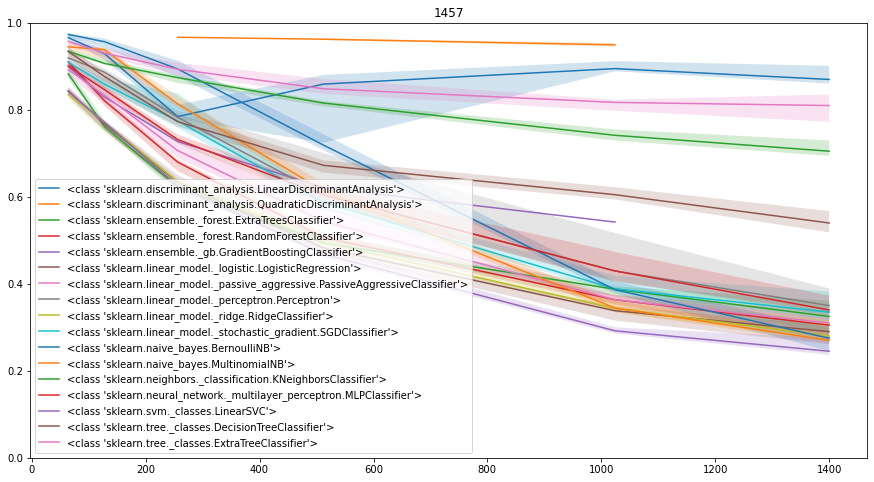

[1 0 2]
[2 1 0]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[1 0 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]


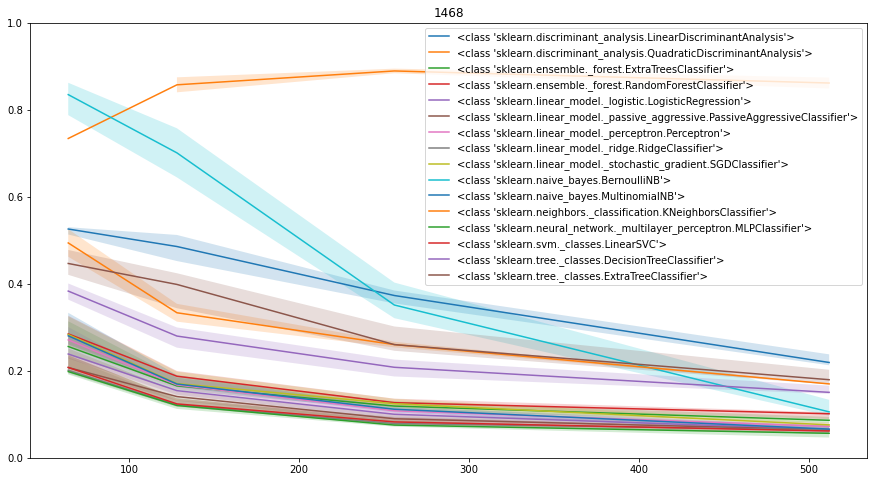

[0 1 2 3 4 5]
[0 1 2 4 5 3]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 3 2 5 4]
[0 1 4 2 3 5]
[0 1 2 3 4 5]
[0 2 1 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]


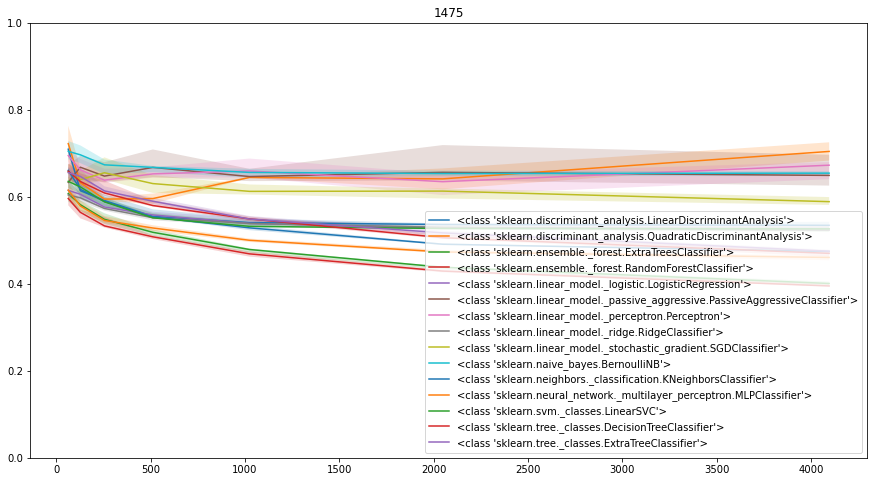

[0 1 3 4 2]
[1 4 3 0 2]
[0 1 2 3 4]
[0 1 2 3 4]
[0 2 3 4 1]
[4 0 3 2 1]
[1 0 3 4 2]
[0 3 4 2 1]
[1 0 2 4 3]
[0 3 1 2 4]
[0 1 2 3 4]
[0 1 2 3 4]
[2 0 3 4 1]
[0 3 2 4 1]
[0 1 2 3 4]
[0 1 2 3 4]


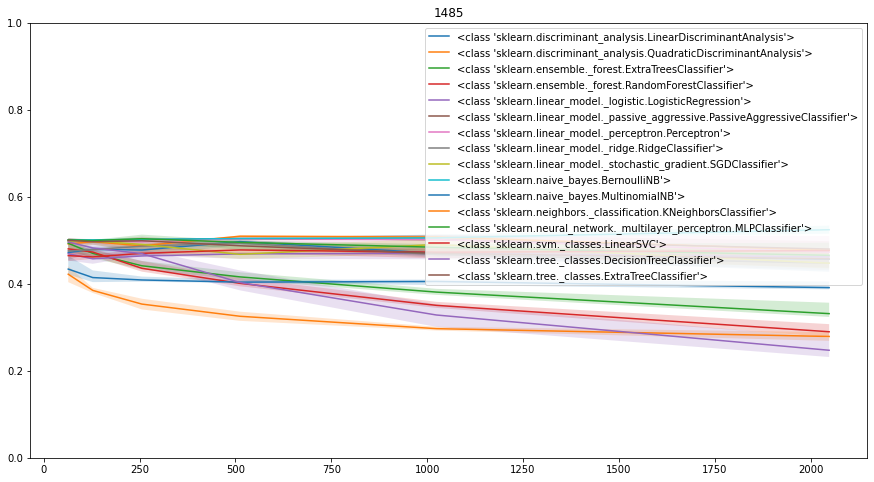

[0 1 2 3 4 5]
[0 3 5 4 1 2]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 3 1 4 5 2]
[0 2 1 3 5 4]
[0 1 2 3 4 5]
[0 2 1 3 4 5]
[0 1 2 3 4 5]
[1 0 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]


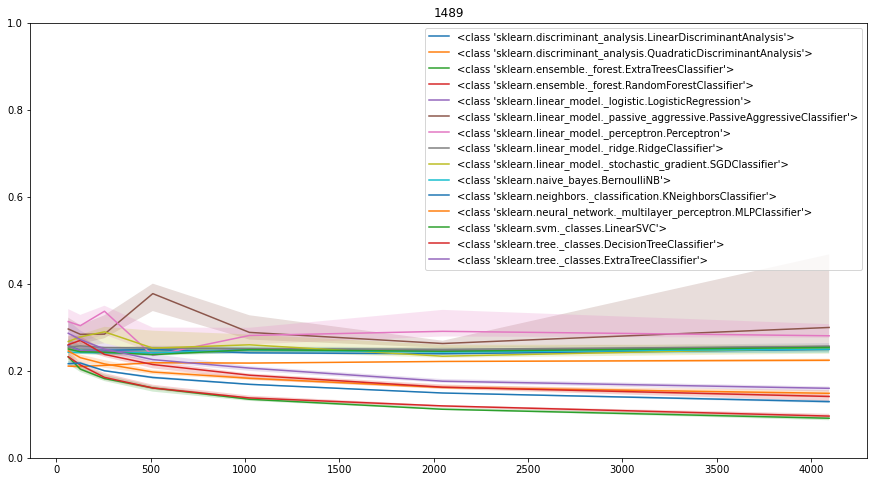

[0 1]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


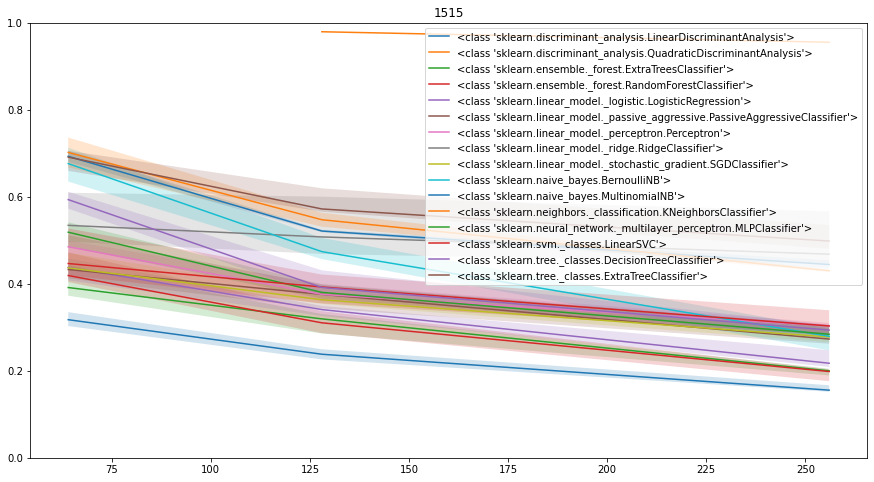

[ 0  1  2  3  4  5  6 10  7  8  9]
[ 0  1  2  3  4  5  6  7 10  9  8]
[ 0  1  2  3  4  5  6  7  8  9 10]
[ 0  1  2  3  4  5  6  7 10  8  9]
[ 0  1  2  3  4  5  6 10  7  8  9]
[ 0  1  2  4  3  5  6 10  8  9  7]
[ 0  1  2  3  4  5  6  7 10  8  9]
[ 0  1  2  3  4  5  6 10  7  8  9]
[ 0  1  2  3  5  4  6  8  7 10  9]
[ 1  0  2  3  4  5  6 10  7  9  8]
[ 0  1  2  3  4  5  6  7  8  9 10]
[ 0  1  2  3  4  5  6  7  8 10  9]
[ 0  1  2  3  4  5  6 10  7  8  9]
[ 0  1  2  3  4  5  6  7  8 10  9]
[ 0  1  2  3  4  5  6  7  8 10  9]


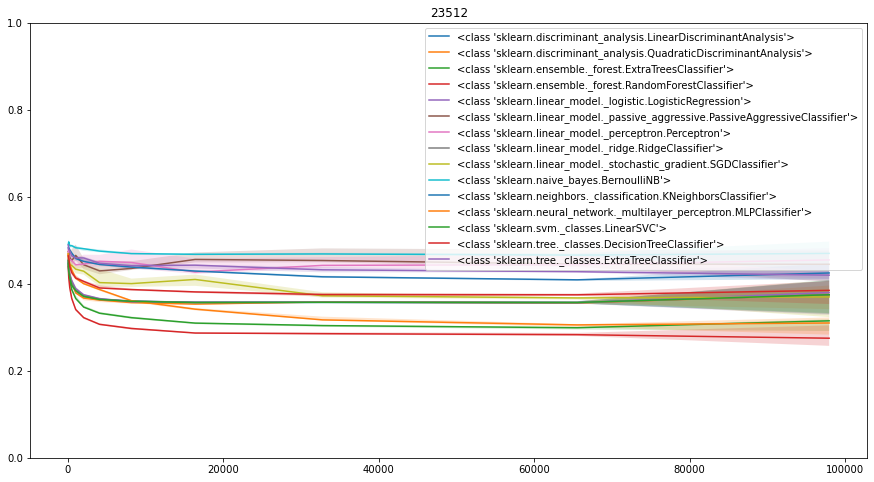

[0 1 2 3 4 5 6 7 8 9]
[0 1 4 3 7 6 8 5 9 2]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 4 3 5 6 7 8 9]
[1 2 4 5 6 3 8 9 7 0]
[0 1 2 4 3 6 7 8 9 5]
[0 1 2 3 4 5 6 7 8 9]
[0 2 4 1 6 5 7 8 9 3]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 3 4 5 7 8 9 6 2]
[0 2 1 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 2 3 1 5 6 7 8 4 9]
[0 1 2 3 5 4 6 7 8 9]


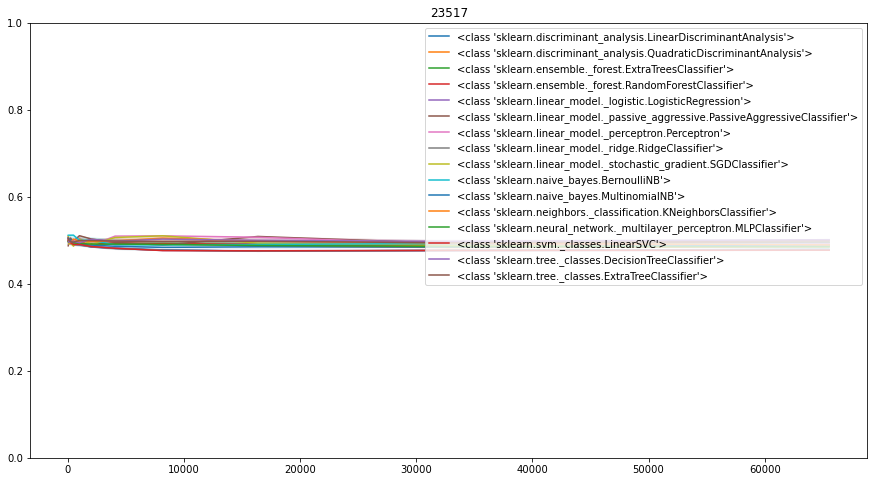

[0 1 2 3 4 5]
[0 1 4 5 2 3]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 4 3 5]
[0 2 4 1 5 3]
[0 1 2 4 3 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[1 2 4 0 3 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 4 3 5]
[0 1 3 4 5 2]
[0 1 2 3 4 5]
[0 1 2 3 4 5]


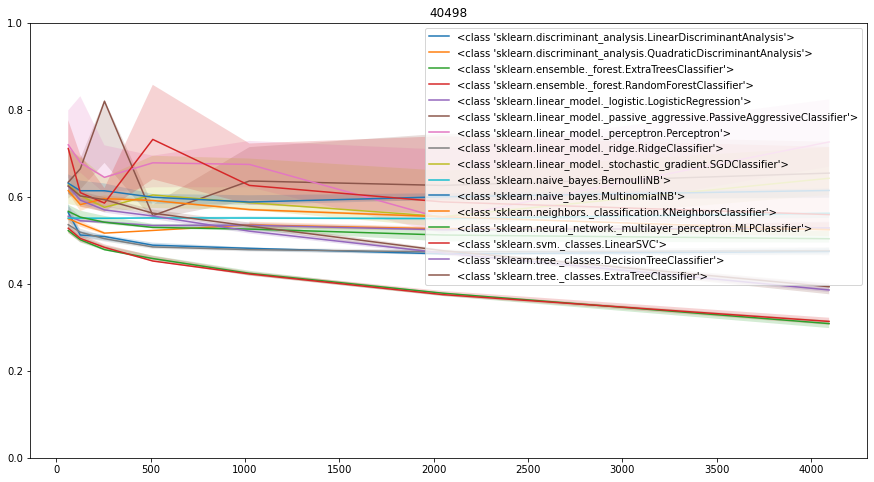

[0 1 2 3 4 5 6 7 8]
[4 0 1 2 3 5 6]
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
[0 2 1 4 5 6 8 7 3]
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
[1 0 2 4 3 7 6 8 5]
[0 1 2 3 4 6 5 8 7]
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
[1 0 2 5 3 6 8 7 4]
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]


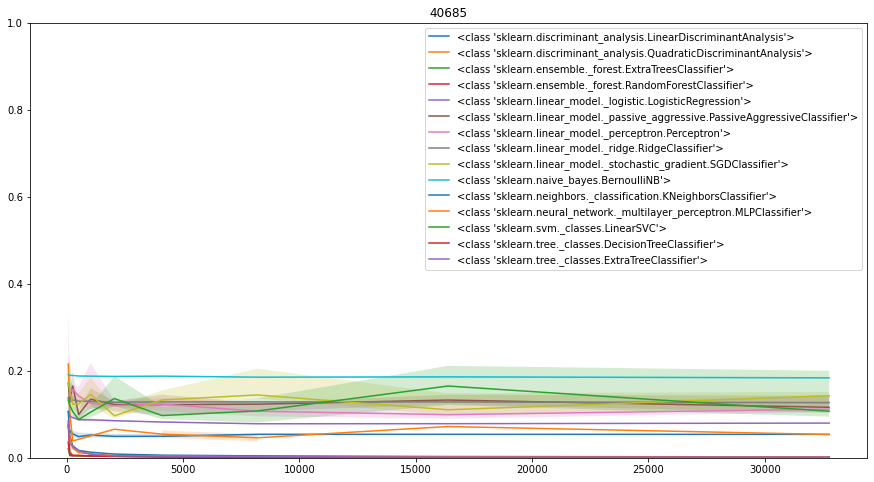

[0 1 2 4 5 3]
[2 1 5 0 3 4]
[0 1 2 3 4 5]
[0 2 1 3 4 5]
[0 1 2 3 4 5]
[1 0 3 2 4 5]
[3 4 0 1 5 2]
[0 1 2 3 4 5]
[0 2 1 4 3 5]
[0 1 2 3 4 5]
[0 2 3 1 4 5]
[3 1 4 5 2 0]
[0 1 2 4 5 3]
[0 1 3 2 5 4]
[0 1 2 3 4 5]
[0 1 2 3 4 5]


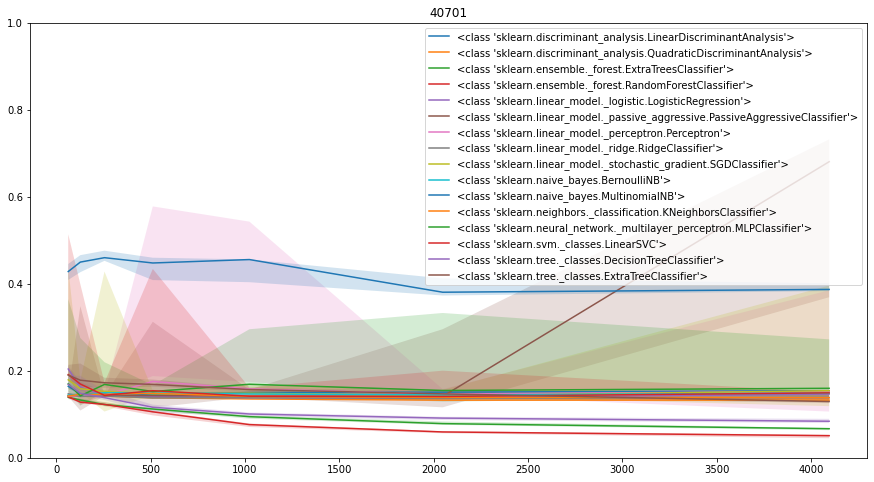

[0 1 2 3 4 5]
[2 3 1 4 0]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 5 4]
[1 2 3 4 5 0]
[0 3 1 5 4 2]
[0 1 2 3 4 5]
[2 3 1 5 4 0]
[2 1 0 3 5 4]
[1 2 0 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]


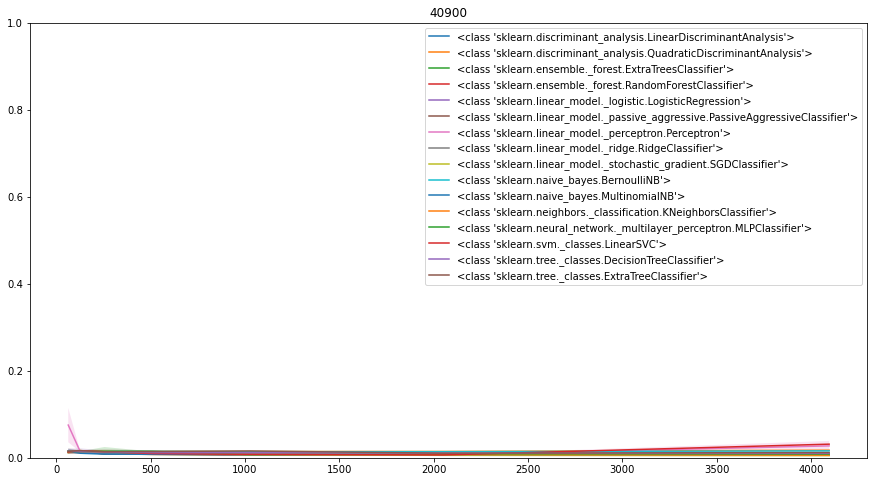

[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 2 1]
[0 1 2]
[0 1 2]
[1 0 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]


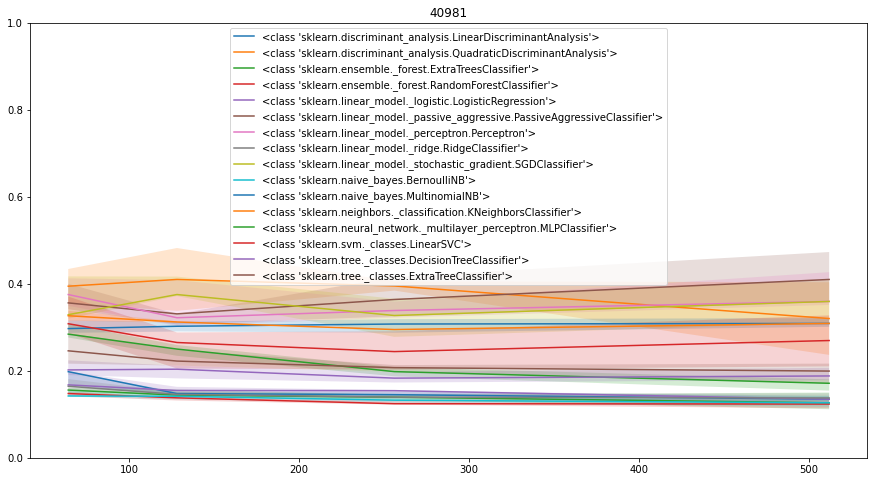

[0 1 2 3]
[1 2 0]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 2 1 3]
[0 1 2 3]
[0 1 2 3]
[0 2 1 3]
[0 1 2 3]
[0 2 3 1]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


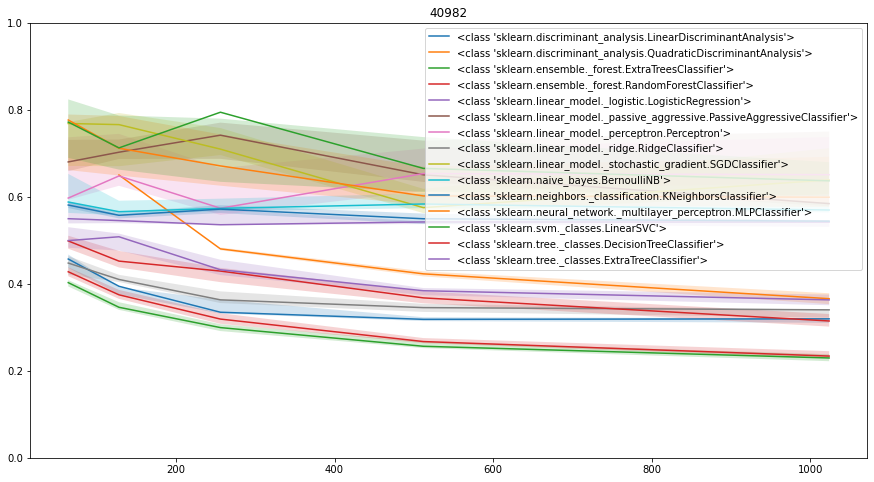

[0 2 3 1 4 5]
[1 2 3 4 5 0]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 4 1 3 5 2]
[0 5 2 1 3 4]
[1 0 2 3 4 5]
[0 2 1 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[1 0 2 3 4 5]
[1 0 2 3 4 5]
[0 2 3 1 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]


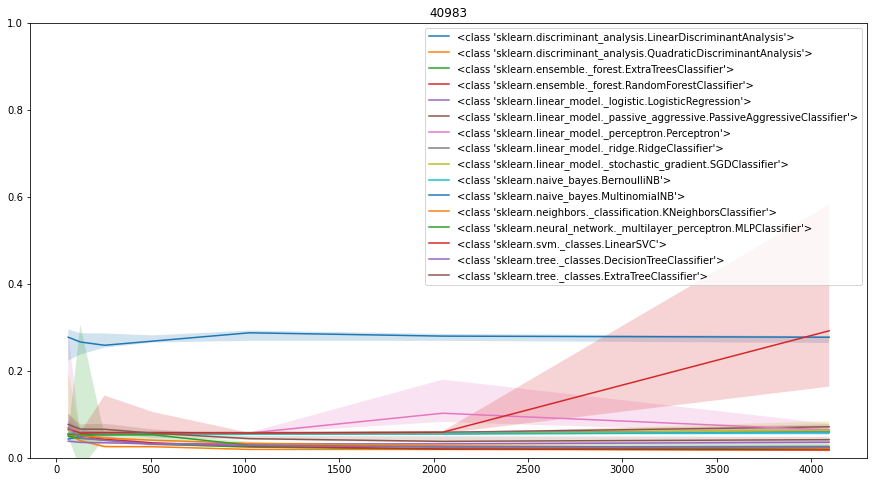

[0 1 2 3 4]
[2 3 4 1 0]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 3 2 4]
[1 0 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 4 3]
[0 1 2 3 4]
[0 1 2 4 3]
[0 2 1 3 4]
[0 1 2 3 4]
[0 1 2 3 4]


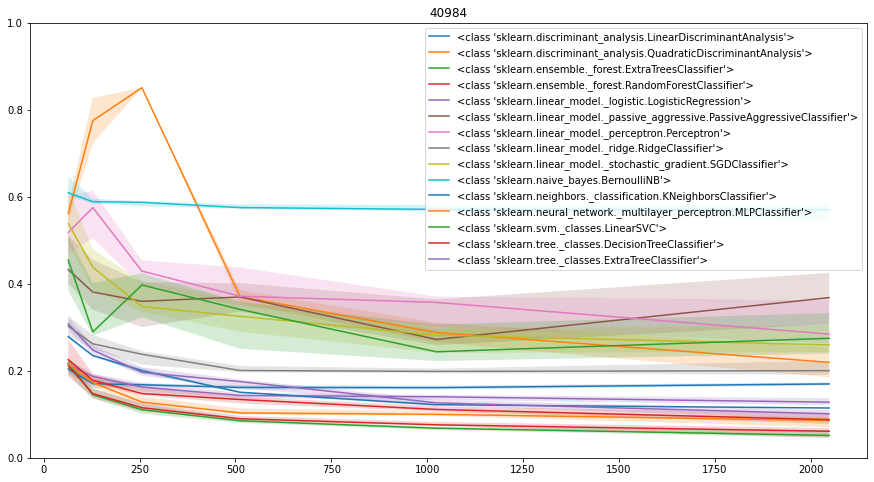

[1 0 2 4 3 6 7 5]
[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 6 7]
[1 0 2 3 4 5 6 7]
[0 2 1 3 4 5 6 7]
[0 2 1 3 4 5 6 7]
[0 1 2 3 4 5 6 7]
[0 1 2 3 4 6 7 5]
[0 1 2 3 4 5 6 7]
[0 2 1 3 4 5 6 7]
[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 6 7]
[0 1 3 2 4 5 6 7]
[0 1 3 2 4 5 6 7]


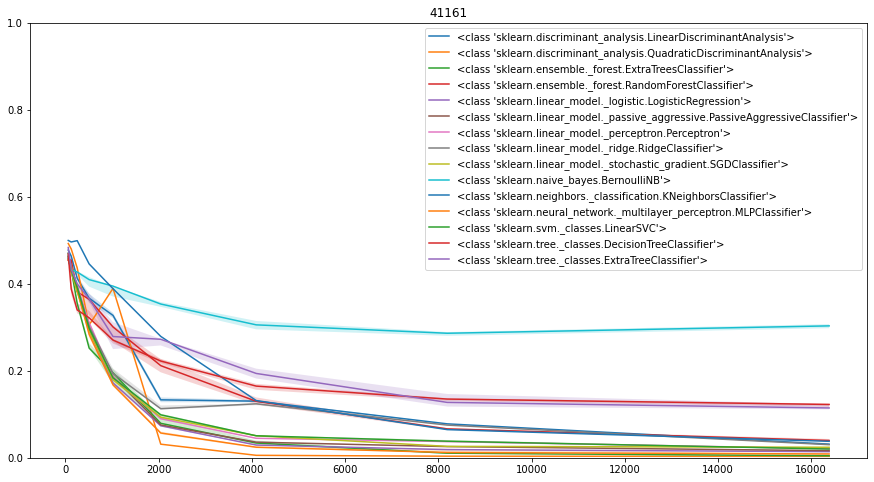

In [11]:
for openmlid, dfDataset in dfCache.groupby("openmlid"):
    fig, ax = plt.subplots(figsize=(15, 8))
    #print(pd.unique(dfCache["openmlid"]))
    for learner, dfLearner in dfDataset.groupby("learner"):
        sizes = sorted(pd.unique(dfLearner["train_size"]))
        values = []
        conf = []
        optimistic_slopes = []
        for i, size in enumerate(sizes):
            values_at_size = dfLearner[dfLearner["train_size"] == size]["error_rate"].values
            #print(values_at_size)
            values.append(np.median(values_at_size))
            mu = np.mean(values_at_size)
            sigma = np.std(values_at_size)
            conf_at_size = scipy.stats.norm.interval(0.95, loc=mu, scale=sigma/np.sqrt(10))
            conf.append(conf_at_size)
            
            if i > 0:
                optimistic_slope = (conf[i][0] - conf[i-1][1]) / (size - sizes[i-1])
                optimistic_slopes.append(optimistic_slope)
        #print(optimistic_slopes)
        print(np.argsort(optimistic_slopes))
                
        conf = np.array(conf)
        ax.plot(sizes, values, label=learner)
        ax.fill_between(sizes, conf[:,0], conf[:,1], alpha=0.2)
        #break
    ax.legend()
    ax.set_title(openmlid)
    ax.set_ylim([0, 1])
    plt.show()